# Generative-Based Chatbot Using Sequence to Sequence Algorithm

In [1]:
import re
import os
import time
import csv
import math
import random
import codecs
import itertools

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import optim
from torch.jit import script, trace

In [2]:
from utils import normalize_string, filter_pairs, indexes_from_sentence, time_since, moving_average, show_plot_evaluation

## Set Configs

In [3]:
PAD_token = 0
SOS_token = 1
EOS_token = 2
MAX_LENGTH = 10
MIN_COUNT = 3

# model configs
LR = 0.0001
N_EPOCHS = 4000
TEACHER_FORCING_RATIO = 1.0
HIDDEN_SIZE = 500
DROPOUT = 0.1
CLIP = 50.0
BATCH_SIZE = 64

ENCODER_N_LAYERS = 2
DECODER_N_LAYERS = 2
DECODER_LEARNING_RATIO = 5.0

In [4]:
is_cuda = torch.cuda.is_available()

if is_cuda: device = torch.device('cuda')
else: device = torch.device('cpu')

## Set Helpers

In [5]:
class Vocabulary:
    
    def __init__(self, name):
        
        super(Vocabulary, self).__init__()
        
        self.name = name
        self.trimmed = False
        self.word2index = {}
        self.word2count = {}
        self.index2word = { PAD_token: 'PAD', SOS_token: 'SOS', EOS_token: 'EOS' }
        self.num_words = 3 # count constant tokens PAD, SOS and EOS
        
    def add_sentence(self, sentence):
        for word in sentence.split(' '):
            self.add_word(word)
            
    def add_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1
            
    # remove words below a certain count threshold
    def trim(self, min_count):

        if self.trimmed: return

        self.trimmed = True

        keep_words = []
        for key, value in self.word2count.items():
            if value >= min_count:
                keep_words.append(key)

        print('Keep Words: {}/{} = {:.4f}'.format(
               len(keep_words), len(self.word2index), len(keep_words) / len(self.word2index)))

        # reinitialize dictionaries
        self.word2index = {}
        self.word2count = {}
        self.index2word = { PAD_token: 'PAD', SOS_token: 'SOS', EOS_token: 'EOS' }
        self.num_words = 3  # count constant tokens PAD, SOS and EOS

        for word in keep_words:
            self.add_word(word)

In [6]:
def read_vocabulary(data_file, corpus_name):
    print('Reading lines...')
    
    # read the file and split into lines
    lines = open(data_file, encoding='utf-8').read().strip().split('\n')
    # split every line into pairs and normalize
    pairs = [[normalize_string(string) for string in l.split('\t')] for l in lines]
    vocabulary = Vocabulary(corpus_name)
    
    return vocabulary, pairs

In [7]:
def load_prepare_data(corpus, corpus_name, data_file, save_dir):
    print('Starting training data preparation...')
    vocabulary, pairs = read_vocabulary(data_file, corpus_name)
    
    print('Reading {!s} sentence pairs'.format(len(pairs)))
    pairs = filter_pairs(pairs, MAX_LENGTH)
    
    print('Trimmed to {!s} sentence pairs'.format(len(pairs)))
    print('Counting words...')
    for pair in pairs:
        vocabulary.add_sentence(pair[0])
        vocabulary.add_sentence(pair[1])
    print(f'Counted words: {vocabulary.num_words}')
    
    return vocabulary, pairs

## Load Datasets

In [8]:
# datasets grasp from here: www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html
corpus_name = 'cornell_movie_dialogs'
corpus = os.path.join('datasets', corpus_name)

In [9]:
def print_lines(file, n=10):
    with open(file, 'rb') as data:
        lines = data.readlines()
    for line in lines[:n]:
        print(line)

In [10]:
print_lines(os.path.join(corpus, 'movie_lines.txt'))

b'L1045 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ They do not!\n'
b'L1044 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ They do to!\n'
b'L985 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ I hope so.\n'
b'L984 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ She okay?\n'
b"L925 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Let's go.\n"
b'L924 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ Wow\n'
b"L872 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Okay -- you're gonna need to learn how to lie.\n"
b'L871 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ No\n'
b'L870 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ I\'m kidding.  You know how sometimes you just become this "persona"?  And you don\'t know how to quit?\n'
b'L869 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Like my fear of wearing pastels?\n'


## Preprocess Datasets

In [11]:
def load_lines(file_name, fields):
    
    lines = {}
    with open(file_name, 'r', encoding='iso-8859-1') as f:
        for line in f:
            values = line.split(' +++$+++ ')
            
            line_obj = {}
            for i, field in enumerate(fields):
                line_obj[field] = values[i]
            
            lines[line_obj['lineID']] = line_obj
    return lines

In [12]:
def load_conversations(file_name, lines, fields):
    
    conversations = []
    with open(file_name, 'r', encoding='iso-8859-1') as f:
        for line in f:
            values = line.split(" +++$+++ ")
            
            conv_obj = {}
            for i, field in enumerate(fields):
                conv_obj[field] = values[i]
                
            utterance_id_pattern = re.compile('L[0-9]+')
            line_ids = utterance_id_pattern.findall(conv_obj['utteranceIDs'])
            
            conv_obj['lines'] = []
            for line_id in line_ids:
                conv_obj['lines'].append(lines[line_id])
                
            conversations.append(conv_obj)
    return conversations

In [13]:
def extract_sentence_pairs(conversations):
    
    qa_pairs = []
    for conversation in conversations:
        for i in range(len(conversation['lines']) - 1):
            input_line = conversation['lines'][i]['text'].strip()
            target_line = conversation['lines'][i+1]['text'].strip()
            
            if input_line and target_line:
                qa_pairs.append([input_line, target_line])
                
    return qa_pairs

In [14]:
data_file = os.path.join(corpus, 'formatted_movie_lines.txt')

delimiter = '\t'
delimiter = str(codecs.decode(delimiter, 'unicode_escape'))

In [15]:
lines = {}
conversations = []
MOVIE_LINES_FIELDS = ['lineID', 'characterID', 'movieID', 'character', 'text']
MOVIE_CONVERSATIONS_FIELDS = ['character1ID', 'character2ID', 'movieID', 'utteranceIDs']

print('\nProcessing corpus...')
lines = load_lines(os.path.join(corpus, 'movie_lines.txt'), MOVIE_LINES_FIELDS)

print('\nLoading conversations...')
conversations = load_conversations(os.path.join(corpus, 'movie_conversations.txt'),
                                   lines, MOVIE_CONVERSATIONS_FIELDS)

print('\nWriting newly formatted file...')
with open(data_file, 'w', encoding='utf-8') as output_file:
    writer = csv.writer(output_file, delimiter=delimiter, lineterminator='\n')
    for pair in extract_sentence_pairs(conversations):
        writer.writerow(pair)
        
print('\nSample lines from file:')
print_lines(data_file)


Processing corpus...

Loading conversations...

Writing newly formatted file...

Sample lines from file:
b"Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.\tWell, I thought we'd start with pronunciation, if that's okay with you.\n"
b"Well, I thought we'd start with pronunciation, if that's okay with you.\tNot the hacking and gagging and spitting part.  Please.\n"
b"Not the hacking and gagging and spitting part.  Please.\tOkay... then how 'bout we try out some French cuisine.  Saturday?  Night?\n"
b"You're asking me out.  That's so cute. What's your name again?\tForget it.\n"
b"No, no, it's my fault -- we didn't have a proper introduction ---\tCameron.\n"
b"Cameron.\tThe thing is, Cameron -- I'm at the mercy of a particularly hideous breed of loser.  My sister.  I can't date until she does.\n"
b"The thing is, Cameron -- I'm at the mercy of a particularly hideous breed of loser.  My sister.  I can't dat

In [16]:
save_dir = os.path.join('datasets', 'save')
vocabulary, pairs = load_prepare_data(corpus, corpus_name, data_file, save_dir)

print('\nPairs:')
for pair in pairs[:10]: print(pair)

Starting training data preparation...
Reading lines...
Reading 221282 sentence pairs
Trimmed to 64271 sentence pairs
Counting words...
Counted words: 18008

Pairs:
['there .', 'where ?']
['you have my word . as a gentleman', 'you re sweet .']
['hi .', 'looks like things worked out tonight huh ?']
['you know chastity ?', 'i believe we share an art instructor']
['have fun tonight ?', 'tons']
['well no . . .', 'then that s all you had to say .']
['then that s all you had to say .', 'but']
['but', 'you always been this selfish ?']
['do you listen to this crap ?', 'what crap ?']
['what good stuff ?', 'the real you .']


In [17]:
def trim_rare_words(vocabulary, pairs, min_count):
    
    vocabulary.trim(min_count)
    
    keep_pairs = []
    for pair in pairs:
        input_sentence = pair[0]
        output_sentence = pair[1]
        
        keep_input = True
        keep_output = True
        
        # check input sentence
        for word in input_sentence.split(' '):
            if word not in vocabulary.word2index:
                keep_input = False
                break
           
        # check output sentence
        for word in output_sentence.split(' '):
            if word not in vocabulary.word2index:
                keep_output = False
                break
                
        # only keep pairs that do not contain trimmed word(s) in their input or output sentence
        if keep_input and keep_output:
            keep_pairs.append(pair)
            
    print('Trimmed from {} pairs to {}, {:.4f} of total.'.format(len(pairs), len(keep_pairs), len(keep_pairs) / len(pairs)))
    return keep_pairs

In [18]:
pairs = trim_rare_words(vocabulary, pairs, MIN_COUNT)

print('\nPairs:')
for pair in pairs[:10]: print(pair)

Keep Words: 7823/18005 = 0.4345
Trimmed from 64271 pairs to 53165, 0.8272 of total.

Pairs:
['there .', 'where ?']
['you have my word . as a gentleman', 'you re sweet .']
['hi .', 'looks like things worked out tonight huh ?']
['have fun tonight ?', 'tons']
['well no . . .', 'then that s all you had to say .']
['then that s all you had to say .', 'but']
['but', 'you always been this selfish ?']
['do you listen to this crap ?', 'what crap ?']
['what good stuff ?', 'the real you .']
['wow', 'let s go .']


## Prepare Datasets for Model

In [19]:
def zero_padding(l, fillvalue=PAD_token):
    return list(itertools.zip_longest(*l, fillvalue=fillvalue))

In [20]:
def binary_matrix(l, value=PAD_token):
    matrix = []
    for i, sequence in enumerate(l):
        matrix.append([])
        for token in sequence:
            if token == PAD_token:
                matrix[i].append(0)
            else:
                matrix[i].append(1)
    
    return matrix

In [21]:
# returns padded input sequence tensor and lengths
def input_var(l, vocabulary):
    
    indexes_batch = [indexes_from_sentence(vocabulary, sentence, EOS_token) for sentence in l]
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    pad_list = zero_padding(indexes_batch)
    pad_var = torch.LongTensor(pad_list)
    
    return pad_var, lengths

In [22]:
# returns padded target sequence tensor, padding mask and max target length
def output_var(l, vocabulary):
    
    indexes_batch = [indexes_from_sentence(vocabulary, sentence, EOS_token) for sentence in l]
    max_target_len = max([len(indexes) for indexes in indexes_batch])
    pad_list = zero_padding(indexes_batch)
    mask = binary_matrix(pad_list)
    mask = torch.BoolTensor(mask)
    pad_var = torch.LongTensor(pad_list)
    
    return pad_var, mask, max_target_len

In [23]:
# returns all items for a given batch of pairs
def batch_to_train_data(vocabulary, pair_batch):
    
    pair_batch.sort(key=lambda x: len(x[0].split(' ')), reverse=True)
    input_batch, output_batch = [], []
    for pair in pair_batch:
        input_batch.append(pair[0])
        output_batch.append(pair[1])
    
    inp, lengths = input_var(input_batch, vocabulary)
    output, mask, max_target_len = output_var(output_batch, vocabulary)
    
    return inp, lengths, output, mask, max_target_len

In [24]:
SMALL_BATCH_SIZE = 5

In [25]:
batches = batch_to_train_data(vocabulary, [random.choice(pairs) for _ in range(SMALL_BATCH_SIZE)])
input_variable, lengths, target_variable, mask, max_target_len = batches

print("Input Variable:", input_variable)
print("Lengths:", lengths)
print("Target Variable:", target_variable)
print("Mask:", mask)
print("Max Target Len:", max_target_len)

Input Variable: tensor([[  27,   27,   47,    7, 1600],
        [  14,   14,    7,    8,    4],
        [ 123,   67,   43,   12,    2],
        [  40,  123,    8, 4415,    0],
        [ 216,   40,   40, 2049,    0],
        [  76,  112, 1223,    6,    0],
        [  38, 5384,    6,    2,    0],
        [   4,   66,    2,    0,    0],
        [   2,    2,    0,    0,    0]])
Lengths: tensor([9, 9, 8, 7, 3])
Target Variable: tensor([[ 562,   36,  483,   25,   62],
        [3273,   27,    4,  379,    4],
        [  65,   92,    2,    8,    2],
        [ 132,    4,    0,   12,    0],
        [5740,    2,    0, 4415,    0],
        [ 386,    0,    0, 2049,    0],
        [  66,    0,    0,  318,    0],
        [   2,    0,    0,    4,    0],
        [   0,    0,    0,    2,    0]])
Mask: tensor([[ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True, False,  True, False],
        [ True,  True, Fal

## Build [Seq2seq](https://arxiv.org/pdf/1409.3215.pdf) Network

In [26]:
class Encoder(nn.Module):
    
    def __init__(self, hidden_size, embedding, n_layers=1, dropout=0):
        super(Encoder, self).__init__()
        
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding_layer = embedding
        
        # initialize GRU: the input size and hidden size params are bot set to 'hidden_size'
        # because our input size is a word embedding with number of features equals to 'hidden_size'
        self.gru_layer = nn.GRU(hidden_size, hidden_size, n_layers,
                                dropout=(0 if n_layers == 1 else dropout), bidirectional=True)
        
    def forward(self, input_seq, input_lengths, hidden=None):
        
        # convert word indexes to embeddings
        embeds = self.embedding_layer(input_seq) # input_seq: (max_length, batch_size)
        
        # pack padded batch of sequences for RNN module
        packed = nn.utils.rnn.pack_padded_sequence(embeds, input_lengths)
        
        # forward pass through GRU layer
        gru_out, hidden = self.gru_layer(packed, hidden) # hidden shape: (n_layers x num_directions, batch_size, hidden_size)
        
        # unpack the padding
        outputs, _ = nn.utils.rnn.pad_packed_sequence(gru_out) # outputs shape: (max_length, batch_size, hidden_size)
        
        # sum bidirectional GRU outputs
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, :, self.hidden_size:]
        
        # return outputs and final hidden state
        return outputs, hidden

## Build [Attention](https://arxiv.org/pdf/1706.03762.pdf) Decoder Network

In [27]:
class GlobalAttention(nn.Module):
    
    def __init__(self, method, hidden_size):
        
        super(GlobalAttention, self).__init__()
        
        self.method = method
        
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, 'is not an appropriate attention method.')
        
        self.hidden_size = hidden_size
        
        if self.method == 'general':
            self.attention_layer = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(hidden_size))
            
    def dot_score(self, hidden, encoder_output):
        return torch.sum(hidden * encoder_output, dim=2)
    
    def general_score(self, hidden, encoder_output):
        energy = self.attention_layer(encoder_output)
        return torch.sum(hidden * energy, dim=2)
    
    def concat_score(self, hidden, encoder_output):
        energy = self.attention_layer(torch.cat((hidden.expand(encoder_output.size(0), -1, -1), encoder_output), 2)).tanh()
        return torch.sum(self.v * energy, dim=2)
    
    def forward(self, hidden, encoder_outputs):
        # calculate the attention weights (energies) based on the given method
        if self.method == 'general':
            attention_energies = self.general_score(hidden, encoder_outputs)
        elif self.method == 'concat':
            attention_energies = self.concat_score(hidden, encoder_outputs)
        elif self.method == 'dot':
            attention_energies = self.dot_score(hidden, encoder_outputs)
            
        # transpose max_length and batch_size dimensions
        attention_energies = attention_energies.t()
        
        # return the softmax normalized probability scores (with added dimension)
        return F.softmax(attention_energies, dim=1).unsqueeze(1)

In [28]:
class GlobalAttentionDecoder(nn.Module):
    
    # input_step shape: (1, batch_size)
    # last_hidden shape: (n_layers x num_directions, batch_size, hidden_size)
    # encoder_outputs shape: (max_length, batch_size, hidden_size)
    def __init__(self, embedding, hidden_size, output_size, n_layers=1, dropout=0.1, attention_method='dot'):
        
        super(GlobalAttentionDecoder, self).__init__()
        
        self.attention_method = attention_method
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout
        
        # define layers
        self.embedding_layer = embedding
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru_layer = nn.GRU(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout))
        self.concat_layer = nn.Linear(hidden_size * 2, hidden_size)
        self.fc_layer = nn.Linear(hidden_size, output_size)
        
        self.attention_layer = GlobalAttention(attention_method, hidden_size)
    
    # output shape: (batch_size, vocabulary.num_words)
    # hidden shape: (n_layers x num_directions, batch_size, hidden_size)
    def forward(self, input_step, last_hidden, encoder_outputs):
        
        # run this one step (word) at a time
        embeds = self.embedding_layer(input_step)
        embeds = self.embedding_dropout(embeds)
        
        # forward through undirectional GRU
        gru_out, hidden = self.gru_layer(embeds, last_hidden)
        
        # calculate attention weights from the current GRU output
        attention_weights = self.attention_layer(gru_out, encoder_outputs)
        
        # multiply attention weights to encoder outputs to get new 'weighted sum' context vector
        context_vector = attention_weights.bmm(encoder_outputs.transpose(0, 1))
        
        # concatenate weighted context vector and GRU output
        gru_out = gru_out.squeeze(0)
        
        context_vector = context_vector.squeeze(1)
        concat_input = torch.cat((gru_out, context_vector), 1)
        concat_output = torch.tanh(self.concat_layer(concat_input))
        
        # predict next word
        output = self.fc_layer(concat_output)
        output = F.softmax(output, dim=1)
        
        # return output and final hidden state
        return output, hidden

#### Initialize Seq2seq Network

In [29]:
EMBEDDING = nn.Embedding(vocabulary.num_words, HIDDEN_SIZE)

In [30]:
encoder = Encoder(HIDDEN_SIZE, EMBEDDING, ENCODER_N_LAYERS, DROPOUT)
encoder.to(device)

Encoder(
  (embedding_layer): Embedding(7826, 500)
  (gru_layer): GRU(500, 500, num_layers=2, dropout=0.1, bidirectional=True)
)

In [31]:
decoder = GlobalAttentionDecoder(EMBEDDING, HIDDEN_SIZE, vocabulary.num_words, DECODER_N_LAYERS, DROPOUT, attention_method='dot')
decoder.to(device)

GlobalAttentionDecoder(
  (embedding_layer): Embedding(7826, 500)
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (gru_layer): GRU(500, 500, num_layers=2, dropout=0.1)
  (concat_layer): Linear(in_features=1000, out_features=500, bias=True)
  (fc_layer): Linear(in_features=500, out_features=7826, bias=True)
  (attention_layer): GlobalAttention()
)

## Set Loss Function

In [32]:
def mask_nll_loss(input_seq, target_seq, mask):
    
    n_total = mask.sum()
    cross_entropy = -torch.log(torch.gather(input_seq, 1, target_seq.view(-1, 1)).squeeze(1))
    loss = cross_entropy.masked_select(mask).mean()
    loss = loss.to(device)
    
    return loss, n_total.item()

## Set Optimizer

In [33]:
encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=LR)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=LR * DECODER_LEARNING_RATIO)

## Train Seq2seq Network

Sequence of Operations:

1. Forward pass entire input batch through encoder
2. Initialize decoder inputs as SOS_token, and hidden state as the encoder’s final hidden state
3. Forward input batch sequence through decoder one time step at a time
4. If teacher forcing: set next decoder input as the current target; else: set next decoder input as current decoder output
5. Calculate and accumulate loss
6. Perform backpropagation
7. Clip gradients
8. Update encoder and decoder model parameters

In [ ]:
tick = time.time()
losses_history = []
total_loss_print = 0; total_loss_plot = 0

print_every = 1
plot_every = 100
save_every = 20

In [34]:
print('Training the network...')
for epoch in range(1, N_EPOCHS+1):
    
    training_batches = [batch_to_train_data(vocabulary, [random.choice(pairs) for _ in range(BATCH_SIZE)])
                        for _ in range(N_EPOCHS)]
    
    training_batch = training_batches[epoch - 1]
    
    # extract fields from batch
    input_variable, lengths, target_variable, mask, max_target_len = training_batch
    
    # zero gradients
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    # set device options
    input_variable = input_variable.to(device)
    lengths = lengths.to(device)
    target_variable = target_variable.to(device)
    mask = mask.to(device)
    
    # initialize variables
    loss = 0
    print_losses = []
    n_totals = 0
    
    # forward pass through encoder
    encoder_outputs, encoder_hidden = encoder(input_variable, lengths)
    
    # create initial decoder input (start with SOS tokens for each sentence)
    decoder_input = torch.LongTensor([[SOS_token for _ in range(BATCH_SIZE)]])
    decoder_input = decoder_input.to(device)
    
    # set initial decoder hidden state to the encoder's final hidden state
    decoder_hidden = encoder_hidden[:decoder.n_layers]
    
    # determine if we are using teacher forching this iteration
    USE_TEACHER_FORCING = True if random.random() < TEACHER_FORCING_RATIO else False
    
    # forward batch of sequences through decoder one time step at a time
    if USE_TEACHER_FORCING:
        
        for t in range(max_target_len):
            
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)
            
            # teacher forcing: next input is current target
            decoder_input = target_variable[t].view(1, -1)
            
            # calculate and accumulate loss
            mask_loss, n_total = mask_nll_loss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * n_total)
            n_totals += n_total
    else:
        
        for t in range(max_target_len):
            
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)
            
            # no teacher forcing: next input is decoder's own current output
            _, topi = decoder_output.topk(1)
            decoder_input = torch.LongTensor([[topi[i][0] for i in range(BATCH_SIZE)]])
            decoder_input = decoder_input.to(device)
            
            # calculate and accumulate loss
            mask_loss, n_total = mask_nll_loss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * n_total)
            n_totals += n_total
    
    # perform backpropagation
    loss.backward()
    
    # clip gradients
    nn.utils.clip_grad_norm_(encoder.parameters(), CLIP)
    nn.utils.clip_grad_norm_(decoder.parameters(), CLIP)
    
    # adjust model weights
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    loss = sum(print_losses) / n_totals
    total_loss_print += loss
    total_loss_plot += loss
    
    if epoch % print_every == 0:
        avg_loss_print = total_loss_print / print_every
        print('Epoch %d, Average Loss: %.4f, Times Taken: %s' % (epoch, avg_loss_print,
                                                                 time_since(tick, epoch / N_EPOCHS)))
        total_loss_print = 0
    
    if epoch % plot_every == 0:
        avg_loss_plot = total_loss_plot / plot_every
        losses_history.append(avg_loss_plot)
        total_loss_plot = 0
        
    if epoch % save_every == 0:
        torch.save({
            'epoch': epoch,
            'encoder': encoder.state_dict(),
            'decoder': decoder.state_dict(),
            'encoder_opt': encoder_optimizer.state_dict(),
            'decoder_opt': decoder_optimizer.state_dict(),
            'loss': loss,
            'vocab_dict': vocabulary.__dict__,
            'embedding': EMBEDDING.state_dict()
        }, f'./weights/chatbot_weight_{epoch}.hdf5')

Training the network...
Epoch 1, Average Loss: 8.9569, Times Taken: 0m 1s (- 126m 46s)
Epoch 2, Average Loss: 8.8549, Times Taken: 0m 3s (- 121m 8s)
Epoch 3, Average Loss: 8.6870, Times Taken: 0m 5s (- 121m 34s)
Epoch 4, Average Loss: 8.4371, Times Taken: 0m 7s (- 121m 34s)
Epoch 5, Average Loss: 8.0496, Times Taken: 0m 9s (- 124m 58s)
Epoch 6, Average Loss: 7.4691, Times Taken: 0m 11s (- 123m 10s)
Epoch 7, Average Loss: 6.9917, Times Taken: 0m 12s (- 123m 4s)
Epoch 8, Average Loss: 6.8732, Times Taken: 0m 14s (- 121m 59s)
Epoch 9, Average Loss: 6.6860, Times Taken: 0m 16s (- 123m 8s)
Epoch 10, Average Loss: 6.5693, Times Taken: 0m 18s (- 124m 41s)
Epoch 11, Average Loss: 6.2167, Times Taken: 0m 20s (- 123m 34s)
Epoch 12, Average Loss: 5.6564, Times Taken: 0m 22s (- 122m 27s)
Epoch 13, Average Loss: 5.5527, Times Taken: 0m 24s (- 123m 2s)
Epoch 14, Average Loss: 5.7873, Times Taken: 0m 25s (- 122m 18s)
Epoch 15, Average Loss: 5.6728, Times Taken: 0m 27s (- 122m 31s)
Epoch 16, Average L

Epoch 128, Average Loss: 4.3897, Times Taken: 4m 5s (- 123m 34s)
Epoch 129, Average Loss: 4.1131, Times Taken: 4m 6s (- 123m 29s)
Epoch 130, Average Loss: 4.2215, Times Taken: 4m 8s (- 123m 23s)
Epoch 131, Average Loss: 4.2867, Times Taken: 4m 10s (- 123m 23s)
Epoch 132, Average Loss: 4.3196, Times Taken: 4m 12s (- 123m 16s)
Epoch 133, Average Loss: 4.3939, Times Taken: 4m 14s (- 123m 18s)
Epoch 134, Average Loss: 4.2551, Times Taken: 4m 16s (- 123m 8s)
Epoch 135, Average Loss: 4.5336, Times Taken: 4m 18s (- 123m 7s)
Epoch 136, Average Loss: 4.2317, Times Taken: 4m 19s (- 123m 1s)
Epoch 137, Average Loss: 4.0619, Times Taken: 4m 22s (- 123m 8s)
Epoch 138, Average Loss: 4.5230, Times Taken: 4m 24s (- 123m 15s)
Epoch 139, Average Loss: 4.3148, Times Taken: 4m 26s (- 123m 12s)
Epoch 140, Average Loss: 4.2807, Times Taken: 4m 27s (- 123m 5s)
Epoch 141, Average Loss: 4.1787, Times Taken: 4m 30s (- 123m 18s)
Epoch 142, Average Loss: 4.4645, Times Taken: 4m 32s (- 123m 29s)
Epoch 143, Average

Epoch 253, Average Loss: 4.0365, Times Taken: 7m 57s (- 117m 50s)
Epoch 254, Average Loss: 4.1969, Times Taken: 7m 59s (- 117m 45s)
Epoch 255, Average Loss: 4.0018, Times Taken: 8m 0s (- 117m 40s)
Epoch 256, Average Loss: 3.6702, Times Taken: 8m 2s (- 117m 37s)
Epoch 257, Average Loss: 3.9168, Times Taken: 8m 4s (- 117m 32s)
Epoch 258, Average Loss: 4.2808, Times Taken: 8m 5s (- 117m 27s)
Epoch 259, Average Loss: 3.8457, Times Taken: 8m 7s (- 117m 22s)
Epoch 260, Average Loss: 4.2379, Times Taken: 8m 9s (- 117m 17s)
Epoch 261, Average Loss: 3.8480, Times Taken: 8m 10s (- 117m 12s)
Epoch 262, Average Loss: 4.0762, Times Taken: 8m 12s (- 117m 7s)
Epoch 263, Average Loss: 4.1315, Times Taken: 8m 14s (- 117m 3s)
Epoch 264, Average Loss: 4.0394, Times Taken: 8m 15s (- 116m 59s)
Epoch 265, Average Loss: 4.1768, Times Taken: 8m 18s (- 117m 0s)
Epoch 266, Average Loss: 4.0951, Times Taken: 8m 19s (- 116m 56s)
Epoch 267, Average Loss: 3.7831, Times Taken: 8m 21s (- 116m 51s)
Epoch 268, Average 

Epoch 377, Average Loss: 3.7682, Times Taken: 11m 31s (- 110m 42s)
Epoch 378, Average Loss: 3.7244, Times Taken: 11m 32s (- 110m 40s)
Epoch 379, Average Loss: 4.1612, Times Taken: 11m 34s (- 110m 38s)
Epoch 380, Average Loss: 3.9781, Times Taken: 11m 36s (- 110m 35s)
Epoch 381, Average Loss: 3.5998, Times Taken: 11m 38s (- 110m 31s)
Epoch 382, Average Loss: 3.7028, Times Taken: 11m 39s (- 110m 28s)
Epoch 383, Average Loss: 3.7595, Times Taken: 11m 41s (- 110m 25s)
Epoch 384, Average Loss: 3.8933, Times Taken: 11m 43s (- 110m 22s)
Epoch 385, Average Loss: 3.8636, Times Taken: 11m 45s (- 110m 22s)
Epoch 386, Average Loss: 3.9678, Times Taken: 11m 46s (- 110m 19s)
Epoch 387, Average Loss: 3.9282, Times Taken: 11m 48s (- 110m 17s)
Epoch 388, Average Loss: 4.0094, Times Taken: 11m 50s (- 110m 16s)
Epoch 389, Average Loss: 3.8108, Times Taken: 11m 52s (- 110m 13s)
Epoch 390, Average Loss: 3.9197, Times Taken: 11m 54s (- 110m 11s)
Epoch 391, Average Loss: 3.6984, Times Taken: 11m 56s (- 110m 

Epoch 500, Average Loss: 3.7055, Times Taken: 15m 6s (- 105m 45s)
Epoch 501, Average Loss: 3.9671, Times Taken: 15m 8s (- 105m 45s)
Epoch 502, Average Loss: 4.0378, Times Taken: 15m 10s (- 105m 42s)
Epoch 503, Average Loss: 3.5973, Times Taken: 15m 11s (- 105m 40s)
Epoch 504, Average Loss: 4.0134, Times Taken: 15m 13s (- 105m 39s)
Epoch 505, Average Loss: 3.9931, Times Taken: 15m 15s (- 105m 37s)
Epoch 506, Average Loss: 3.9078, Times Taken: 15m 17s (- 105m 36s)
Epoch 507, Average Loss: 3.5355, Times Taken: 15m 19s (- 105m 34s)
Epoch 508, Average Loss: 3.8958, Times Taken: 15m 21s (- 105m 31s)
Epoch 509, Average Loss: 3.7189, Times Taken: 15m 22s (- 105m 28s)
Epoch 510, Average Loss: 3.9893, Times Taken: 15m 24s (- 105m 27s)
Epoch 511, Average Loss: 3.8925, Times Taken: 15m 26s (- 105m 23s)
Epoch 512, Average Loss: 4.2331, Times Taken: 15m 27s (- 105m 20s)
Epoch 513, Average Loss: 3.7363, Times Taken: 15m 29s (- 105m 18s)
Epoch 514, Average Loss: 3.6230, Times Taken: 15m 31s (- 105m 15

Epoch 623, Average Loss: 3.4290, Times Taken: 18m 34s (- 100m 39s)
Epoch 624, Average Loss: 3.6567, Times Taken: 18m 35s (- 100m 36s)
Epoch 625, Average Loss: 3.4205, Times Taken: 18m 37s (- 100m 33s)
Epoch 626, Average Loss: 3.6245, Times Taken: 18m 39s (- 100m 31s)
Epoch 627, Average Loss: 3.7129, Times Taken: 18m 40s (- 100m 28s)
Epoch 628, Average Loss: 3.5528, Times Taken: 18m 42s (- 100m 26s)
Epoch 629, Average Loss: 3.6969, Times Taken: 18m 43s (- 100m 23s)
Epoch 630, Average Loss: 3.5632, Times Taken: 18m 45s (- 100m 21s)
Epoch 631, Average Loss: 3.8667, Times Taken: 18m 47s (- 100m 18s)
Epoch 632, Average Loss: 3.7816, Times Taken: 18m 48s (- 100m 15s)
Epoch 633, Average Loss: 3.5873, Times Taken: 18m 50s (- 100m 13s)
Epoch 634, Average Loss: 3.7633, Times Taken: 18m 52s (- 100m 12s)
Epoch 635, Average Loss: 3.8672, Times Taken: 18m 54s (- 100m 9s)
Epoch 636, Average Loss: 3.7513, Times Taken: 18m 55s (- 100m 7s)
Epoch 637, Average Loss: 3.5088, Times Taken: 18m 57s (- 100m 5s

Epoch 748, Average Loss: 3.6414, Times Taken: 22m 2s (- 95m 48s)
Epoch 749, Average Loss: 3.5395, Times Taken: 22m 3s (- 95m 46s)
Epoch 750, Average Loss: 3.6436, Times Taken: 22m 5s (- 95m 43s)
Epoch 751, Average Loss: 3.6299, Times Taken: 22m 7s (- 95m 41s)
Epoch 752, Average Loss: 3.6124, Times Taken: 22m 8s (- 95m 39s)
Epoch 753, Average Loss: 3.5901, Times Taken: 22m 10s (- 95m 37s)
Epoch 754, Average Loss: 3.8818, Times Taken: 22m 12s (- 95m 34s)
Epoch 755, Average Loss: 3.8049, Times Taken: 22m 13s (- 95m 32s)
Epoch 756, Average Loss: 3.5816, Times Taken: 22m 15s (- 95m 30s)
Epoch 757, Average Loss: 3.2581, Times Taken: 22m 17s (- 95m 27s)
Epoch 758, Average Loss: 3.7370, Times Taken: 22m 18s (- 95m 25s)
Epoch 759, Average Loss: 3.5784, Times Taken: 22m 20s (- 95m 24s)
Epoch 760, Average Loss: 3.6411, Times Taken: 22m 22s (- 95m 22s)
Epoch 761, Average Loss: 3.5715, Times Taken: 22m 23s (- 95m 20s)
Epoch 762, Average Loss: 3.4123, Times Taken: 22m 25s (- 95m 18s)
Epoch 763, Aver

Epoch 873, Average Loss: 3.5969, Times Taken: 25m 32s (- 91m 27s)
Epoch 874, Average Loss: 3.2836, Times Taken: 25m 33s (- 91m 25s)
Epoch 875, Average Loss: 3.4108, Times Taken: 25m 35s (- 91m 23s)
Epoch 876, Average Loss: 3.4281, Times Taken: 25m 37s (- 91m 21s)
Epoch 877, Average Loss: 3.3538, Times Taken: 25m 38s (- 91m 19s)
Epoch 878, Average Loss: 3.8591, Times Taken: 25m 40s (- 91m 17s)
Epoch 879, Average Loss: 3.2637, Times Taken: 25m 42s (- 91m 15s)
Epoch 880, Average Loss: 3.3807, Times Taken: 25m 43s (- 91m 13s)
Epoch 881, Average Loss: 3.2436, Times Taken: 25m 45s (- 91m 11s)
Epoch 882, Average Loss: 3.6173, Times Taken: 25m 47s (- 91m 9s)
Epoch 883, Average Loss: 3.5505, Times Taken: 25m 49s (- 91m 9s)
Epoch 884, Average Loss: 3.7338, Times Taken: 25m 51s (- 91m 8s)
Epoch 885, Average Loss: 3.5934, Times Taken: 25m 53s (- 91m 9s)
Epoch 886, Average Loss: 3.5979, Times Taken: 25m 56s (- 91m 8s)
Epoch 887, Average Loss: 3.4484, Times Taken: 25m 57s (- 91m 7s)
Epoch 888, Avera

Epoch 998, Average Loss: 3.4630, Times Taken: 29m 54s (- 89m 57s)
Epoch 999, Average Loss: 3.3470, Times Taken: 29m 56s (- 89m 56s)
Epoch 1000, Average Loss: 3.4619, Times Taken: 29m 58s (- 89m 55s)
Epoch 1001, Average Loss: 3.3119, Times Taken: 30m 0s (- 89m 53s)
Epoch 1002, Average Loss: 3.8242, Times Taken: 30m 3s (- 89m 54s)
Epoch 1003, Average Loss: 3.6827, Times Taken: 30m 5s (- 89m 55s)
Epoch 1004, Average Loss: 3.4574, Times Taken: 30m 8s (- 89m 56s)
Epoch 1005, Average Loss: 3.8531, Times Taken: 30m 11s (- 89m 58s)
Epoch 1006, Average Loss: 3.3288, Times Taken: 30m 14s (- 89m 58s)
Epoch 1007, Average Loss: 3.2976, Times Taken: 30m 16s (- 89m 59s)
Epoch 1008, Average Loss: 3.5632, Times Taken: 30m 18s (- 89m 58s)
Epoch 1009, Average Loss: 3.6447, Times Taken: 30m 20s (- 89m 56s)
Epoch 1010, Average Loss: 3.3929, Times Taken: 30m 22s (- 89m 54s)
Epoch 1011, Average Loss: 3.3660, Times Taken: 30m 23s (- 89m 52s)
Epoch 1012, Average Loss: 3.3291, Times Taken: 30m 25s (- 89m 50s)
E

Epoch 1121, Average Loss: 3.4922, Times Taken: 34m 1s (- 87m 22s)
Epoch 1122, Average Loss: 3.2257, Times Taken: 34m 2s (- 87m 20s)
Epoch 1123, Average Loss: 3.2204, Times Taken: 34m 4s (- 87m 17s)
Epoch 1124, Average Loss: 3.3751, Times Taken: 34m 6s (- 87m 15s)
Epoch 1125, Average Loss: 3.2895, Times Taken: 34m 7s (- 87m 13s)
Epoch 1126, Average Loss: 3.8565, Times Taken: 34m 9s (- 87m 11s)
Epoch 1127, Average Loss: 3.6358, Times Taken: 34m 11s (- 87m 8s)
Epoch 1128, Average Loss: 3.3538, Times Taken: 34m 12s (- 87m 6s)
Epoch 1129, Average Loss: 3.5795, Times Taken: 34m 14s (- 87m 5s)
Epoch 1130, Average Loss: 3.3562, Times Taken: 34m 16s (- 87m 2s)
Epoch 1131, Average Loss: 3.5341, Times Taken: 34m 18s (- 87m 1s)
Epoch 1132, Average Loss: 3.7174, Times Taken: 34m 19s (- 86m 59s)
Epoch 1133, Average Loss: 3.4697, Times Taken: 34m 21s (- 86m 56s)
Epoch 1134, Average Loss: 3.3028, Times Taken: 34m 23s (- 86m 54s)
Epoch 1135, Average Loss: 3.4361, Times Taken: 34m 25s (- 86m 52s)
Epoch 

Epoch 1244, Average Loss: 3.3492, Times Taken: 37m 47s (- 83m 44s)
Epoch 1245, Average Loss: 3.2877, Times Taken: 37m 49s (- 83m 42s)
Epoch 1246, Average Loss: 3.1548, Times Taken: 37m 51s (- 83m 40s)
Epoch 1247, Average Loss: 3.2088, Times Taken: 37m 53s (- 83m 38s)
Epoch 1248, Average Loss: 3.3916, Times Taken: 37m 55s (- 83m 37s)
Epoch 1249, Average Loss: 3.3255, Times Taken: 37m 57s (- 83m 35s)
Epoch 1250, Average Loss: 3.3896, Times Taken: 37m 58s (- 83m 33s)
Epoch 1251, Average Loss: 3.2476, Times Taken: 38m 0s (- 83m 31s)
Epoch 1252, Average Loss: 3.1733, Times Taken: 38m 2s (- 83m 29s)
Epoch 1253, Average Loss: 3.6206, Times Taken: 38m 4s (- 83m 27s)
Epoch 1254, Average Loss: 3.2094, Times Taken: 38m 5s (- 83m 25s)
Epoch 1255, Average Loss: 3.5877, Times Taken: 38m 7s (- 83m 22s)
Epoch 1256, Average Loss: 3.3428, Times Taken: 38m 9s (- 83m 21s)
Epoch 1257, Average Loss: 3.4985, Times Taken: 38m 10s (- 83m 19s)
Epoch 1258, Average Loss: 3.5343, Times Taken: 38m 12s (- 83m 17s)
E

Epoch 1367, Average Loss: 3.4388, Times Taken: 41m 27s (- 79m 50s)
Epoch 1368, Average Loss: 3.5551, Times Taken: 41m 28s (- 79m 48s)
Epoch 1369, Average Loss: 3.4445, Times Taken: 41m 30s (- 79m 46s)
Epoch 1370, Average Loss: 2.9948, Times Taken: 41m 32s (- 79m 44s)
Epoch 1371, Average Loss: 3.3040, Times Taken: 41m 33s (- 79m 42s)
Epoch 1372, Average Loss: 3.2735, Times Taken: 41m 35s (- 79m 40s)
Epoch 1373, Average Loss: 3.3926, Times Taken: 41m 37s (- 79m 37s)
Epoch 1374, Average Loss: 3.1357, Times Taken: 41m 38s (- 79m 35s)
Epoch 1375, Average Loss: 3.6109, Times Taken: 41m 40s (- 79m 34s)
Epoch 1376, Average Loss: 3.3219, Times Taken: 41m 42s (- 79m 32s)
Epoch 1377, Average Loss: 3.4397, Times Taken: 41m 44s (- 79m 30s)
Epoch 1378, Average Loss: 3.2945, Times Taken: 41m 46s (- 79m 28s)
Epoch 1379, Average Loss: 3.5930, Times Taken: 41m 48s (- 79m 27s)
Epoch 1380, Average Loss: 3.6032, Times Taken: 41m 50s (- 79m 25s)
Epoch 1381, Average Loss: 3.3469, Times Taken: 41m 52s (- 79m 

Epoch 1490, Average Loss: 3.4238, Times Taken: 45m 10s (- 76m 5s)
Epoch 1491, Average Loss: 3.3433, Times Taken: 45m 12s (- 76m 3s)
Epoch 1492, Average Loss: 3.6538, Times Taken: 45m 13s (- 76m 1s)
Epoch 1493, Average Loss: 3.0686, Times Taken: 45m 16s (- 76m 0s)
Epoch 1494, Average Loss: 3.4010, Times Taken: 45m 17s (- 75m 58s)
Epoch 1495, Average Loss: 3.3969, Times Taken: 45m 19s (- 75m 56s)
Epoch 1496, Average Loss: 3.4287, Times Taken: 45m 21s (- 75m 55s)
Epoch 1497, Average Loss: 3.4461, Times Taken: 45m 23s (- 75m 53s)
Epoch 1498, Average Loss: 3.3014, Times Taken: 45m 25s (- 75m 51s)
Epoch 1499, Average Loss: 3.5370, Times Taken: 45m 26s (- 75m 49s)
Epoch 1500, Average Loss: 3.3384, Times Taken: 45m 28s (- 75m 48s)
Epoch 1501, Average Loss: 3.5934, Times Taken: 45m 30s (- 75m 45s)
Epoch 1502, Average Loss: 3.0941, Times Taken: 45m 32s (- 75m 44s)
Epoch 1503, Average Loss: 3.1113, Times Taken: 45m 34s (- 75m 42s)
Epoch 1504, Average Loss: 3.5596, Times Taken: 45m 35s (- 75m 40s)

Epoch 1613, Average Loss: 3.3098, Times Taken: 49m 51s (- 73m 47s)
Epoch 1614, Average Loss: 3.0032, Times Taken: 49m 54s (- 73m 46s)
Epoch 1615, Average Loss: 3.2966, Times Taken: 49m 56s (- 73m 45s)
Epoch 1616, Average Loss: 3.2751, Times Taken: 49m 59s (- 73m 44s)
Epoch 1617, Average Loss: 3.2484, Times Taken: 50m 1s (- 73m 44s)
Epoch 1618, Average Loss: 3.0918, Times Taken: 50m 4s (- 73m 43s)
Epoch 1619, Average Loss: 3.2454, Times Taken: 50m 6s (- 73m 41s)
Epoch 1620, Average Loss: 3.5616, Times Taken: 50m 9s (- 73m 41s)
Epoch 1621, Average Loss: 3.0969, Times Taken: 50m 12s (- 73m 41s)
Epoch 1622, Average Loss: 3.1579, Times Taken: 50m 15s (- 73m 41s)
Epoch 1623, Average Loss: 3.4506, Times Taken: 50m 18s (- 73m 40s)
Epoch 1624, Average Loss: 3.2436, Times Taken: 50m 20s (- 73m 39s)
Epoch 1625, Average Loss: 3.2986, Times Taken: 50m 23s (- 73m 39s)
Epoch 1626, Average Loss: 3.3489, Times Taken: 50m 26s (- 73m 38s)
Epoch 1627, Average Loss: 3.2882, Times Taken: 50m 28s (- 73m 36s)

Epoch 1736, Average Loss: 3.4282, Times Taken: 54m 52s (- 71m 34s)
Epoch 1737, Average Loss: 2.8915, Times Taken: 54m 55s (- 71m 33s)
Epoch 1738, Average Loss: 2.9409, Times Taken: 54m 57s (- 71m 32s)
Epoch 1739, Average Loss: 3.2823, Times Taken: 55m 0s (- 71m 30s)
Epoch 1740, Average Loss: 3.2093, Times Taken: 55m 2s (- 71m 29s)
Epoch 1741, Average Loss: 3.3303, Times Taken: 55m 5s (- 71m 28s)
Epoch 1742, Average Loss: 3.0037, Times Taken: 55m 8s (- 71m 28s)
Epoch 1743, Average Loss: 3.4901, Times Taken: 55m 10s (- 71m 26s)
Epoch 1744, Average Loss: 3.2883, Times Taken: 55m 13s (- 71m 25s)
Epoch 1745, Average Loss: 3.4115, Times Taken: 55m 15s (- 71m 24s)
Epoch 1746, Average Loss: 3.0292, Times Taken: 55m 17s (- 71m 23s)
Epoch 1747, Average Loss: 3.3837, Times Taken: 55m 20s (- 71m 21s)
Epoch 1748, Average Loss: 3.2096, Times Taken: 55m 22s (- 71m 20s)
Epoch 1749, Average Loss: 3.2429, Times Taken: 55m 24s (- 71m 18s)
Epoch 1750, Average Loss: 3.4447, Times Taken: 55m 26s (- 71m 17s)

Epoch 1859, Average Loss: 3.2908, Times Taken: 59m 15s (- 68m 14s)
Epoch 1860, Average Loss: 3.1066, Times Taken: 59m 17s (- 68m 12s)
Epoch 1861, Average Loss: 3.0374, Times Taken: 59m 19s (- 68m 10s)
Epoch 1862, Average Loss: 3.0680, Times Taken: 59m 21s (- 68m 8s)
Epoch 1863, Average Loss: 3.0505, Times Taken: 59m 22s (- 68m 6s)
Epoch 1864, Average Loss: 3.4812, Times Taken: 59m 24s (- 68m 4s)
Epoch 1865, Average Loss: 3.3961, Times Taken: 59m 26s (- 68m 3s)
Epoch 1866, Average Loss: 3.0798, Times Taken: 59m 28s (- 68m 1s)
Epoch 1867, Average Loss: 3.0464, Times Taken: 59m 30s (- 67m 59s)
Epoch 1868, Average Loss: 3.3635, Times Taken: 59m 32s (- 67m 57s)
Epoch 1869, Average Loss: 3.3477, Times Taken: 59m 34s (- 67m 55s)
Epoch 1870, Average Loss: 3.1543, Times Taken: 59m 36s (- 67m 53s)
Epoch 1871, Average Loss: 2.8821, Times Taken: 59m 38s (- 67m 51s)
Epoch 1872, Average Loss: 3.2192, Times Taken: 59m 40s (- 67m 49s)
Epoch 1873, Average Loss: 3.2233, Times Taken: 59m 42s (- 67m 47s)


Epoch 1982, Average Loss: 3.3883, Times Taken: 63m 12s (- 64m 20s)
Epoch 1983, Average Loss: 3.2508, Times Taken: 63m 14s (- 64m 19s)
Epoch 1984, Average Loss: 2.9914, Times Taken: 63m 16s (- 64m 17s)
Epoch 1985, Average Loss: 3.0915, Times Taken: 63m 18s (- 64m 15s)
Epoch 1986, Average Loss: 3.1138, Times Taken: 63m 20s (- 64m 13s)
Epoch 1987, Average Loss: 3.1740, Times Taken: 63m 21s (- 64m 11s)
Epoch 1988, Average Loss: 2.8659, Times Taken: 63m 23s (- 64m 9s)
Epoch 1989, Average Loss: 3.0237, Times Taken: 63m 26s (- 64m 8s)
Epoch 1990, Average Loss: 3.1268, Times Taken: 63m 27s (- 64m 6s)
Epoch 1991, Average Loss: 3.3375, Times Taken: 63m 29s (- 64m 3s)
Epoch 1992, Average Loss: 3.2864, Times Taken: 63m 31s (- 64m 1s)
Epoch 1993, Average Loss: 3.1912, Times Taken: 63m 33s (- 63m 59s)
Epoch 1994, Average Loss: 3.2542, Times Taken: 63m 34s (- 63m 57s)
Epoch 1995, Average Loss: 3.2539, Times Taken: 63m 36s (- 63m 55s)
Epoch 1996, Average Loss: 3.4178, Times Taken: 63m 38s (- 63m 53s)


Epoch 2105, Average Loss: 3.2584, Times Taken: 66m 55s (- 60m 14s)
Epoch 2106, Average Loss: 3.1486, Times Taken: 66m 57s (- 60m 12s)
Epoch 2107, Average Loss: 3.0944, Times Taken: 66m 58s (- 60m 10s)
Epoch 2108, Average Loss: 3.2277, Times Taken: 67m 0s (- 60m 8s)
Epoch 2109, Average Loss: 2.9913, Times Taken: 67m 2s (- 60m 6s)
Epoch 2110, Average Loss: 3.1524, Times Taken: 67m 3s (- 60m 4s)
Epoch 2111, Average Loss: 3.0672, Times Taken: 67m 5s (- 60m 2s)
Epoch 2112, Average Loss: 2.8395, Times Taken: 67m 7s (- 60m 0s)
Epoch 2113, Average Loss: 3.0690, Times Taken: 67m 8s (- 59m 58s)
Epoch 2114, Average Loss: 3.1406, Times Taken: 67m 10s (- 59m 55s)
Epoch 2115, Average Loss: 3.2098, Times Taken: 67m 12s (- 59m 53s)
Epoch 2116, Average Loss: 3.3554, Times Taken: 67m 14s (- 59m 51s)
Epoch 2117, Average Loss: 3.3092, Times Taken: 67m 15s (- 59m 49s)
Epoch 2118, Average Loss: 3.1778, Times Taken: 67m 17s (- 59m 47s)
Epoch 2119, Average Loss: 3.1060, Times Taken: 67m 18s (- 59m 45s)
Epoch 

Epoch 2229, Average Loss: 3.1295, Times Taken: 70m 21s (- 55m 54s)
Epoch 2230, Average Loss: 2.8355, Times Taken: 70m 23s (- 55m 52s)
Epoch 2231, Average Loss: 3.3017, Times Taken: 70m 25s (- 55m 50s)
Epoch 2232, Average Loss: 3.0406, Times Taken: 70m 26s (- 55m 47s)
Epoch 2233, Average Loss: 3.4457, Times Taken: 70m 29s (- 55m 46s)
Epoch 2234, Average Loss: 3.0873, Times Taken: 70m 31s (- 55m 45s)
Epoch 2235, Average Loss: 3.1329, Times Taken: 70m 33s (- 55m 43s)
Epoch 2236, Average Loss: 3.0981, Times Taken: 70m 36s (- 55m 42s)
Epoch 2237, Average Loss: 3.0021, Times Taken: 70m 38s (- 55m 40s)
Epoch 2238, Average Loss: 2.9327, Times Taken: 70m 41s (- 55m 39s)
Epoch 2239, Average Loss: 3.0659, Times Taken: 70m 44s (- 55m 38s)
Epoch 2240, Average Loss: 3.1712, Times Taken: 70m 45s (- 55m 36s)
Epoch 2241, Average Loss: 3.1486, Times Taken: 70m 47s (- 55m 34s)
Epoch 2242, Average Loss: 3.1547, Times Taken: 70m 49s (- 55m 31s)
Epoch 2243, Average Loss: 2.9620, Times Taken: 70m 50s (- 55m 

Epoch 2352, Average Loss: 3.2546, Times Taken: 73m 51s (- 51m 45s)
Epoch 2353, Average Loss: 2.9005, Times Taken: 73m 53s (- 51m 43s)
Epoch 2354, Average Loss: 3.0075, Times Taken: 73m 55s (- 51m 41s)
Epoch 2355, Average Loss: 2.9801, Times Taken: 73m 56s (- 51m 39s)
Epoch 2356, Average Loss: 2.9075, Times Taken: 73m 58s (- 51m 37s)
Epoch 2357, Average Loss: 2.9189, Times Taken: 74m 0s (- 51m 35s)
Epoch 2358, Average Loss: 2.9908, Times Taken: 74m 1s (- 51m 33s)
Epoch 2359, Average Loss: 3.0040, Times Taken: 74m 3s (- 51m 31s)
Epoch 2360, Average Loss: 3.2165, Times Taken: 74m 5s (- 51m 28s)
Epoch 2361, Average Loss: 3.0670, Times Taken: 74m 6s (- 51m 26s)
Epoch 2362, Average Loss: 3.0690, Times Taken: 74m 8s (- 51m 24s)
Epoch 2363, Average Loss: 2.7324, Times Taken: 74m 10s (- 51m 22s)
Epoch 2364, Average Loss: 3.2034, Times Taken: 74m 11s (- 51m 20s)
Epoch 2365, Average Loss: 2.9166, Times Taken: 74m 13s (- 51m 18s)
Epoch 2366, Average Loss: 3.3950, Times Taken: 74m 15s (- 51m 16s)
E

Epoch 2475, Average Loss: 2.8744, Times Taken: 77m 18s (- 47m 37s)
Epoch 2476, Average Loss: 2.9644, Times Taken: 77m 19s (- 47m 35s)
Epoch 2477, Average Loss: 3.1496, Times Taken: 77m 21s (- 47m 33s)
Epoch 2478, Average Loss: 2.8931, Times Taken: 77m 23s (- 47m 31s)
Epoch 2479, Average Loss: 2.8938, Times Taken: 77m 24s (- 47m 29s)
Epoch 2480, Average Loss: 3.0098, Times Taken: 77m 26s (- 47m 27s)
Epoch 2481, Average Loss: 2.9807, Times Taken: 77m 28s (- 47m 25s)
Epoch 2482, Average Loss: 3.0797, Times Taken: 77m 29s (- 47m 23s)
Epoch 2483, Average Loss: 3.2624, Times Taken: 77m 31s (- 47m 21s)
Epoch 2484, Average Loss: 3.1686, Times Taken: 77m 33s (- 47m 19s)
Epoch 2485, Average Loss: 3.0469, Times Taken: 77m 34s (- 47m 17s)
Epoch 2486, Average Loss: 2.7927, Times Taken: 77m 36s (- 47m 15s)
Epoch 2487, Average Loss: 3.0369, Times Taken: 77m 38s (- 47m 13s)
Epoch 2488, Average Loss: 3.0133, Times Taken: 77m 39s (- 47m 11s)
Epoch 2489, Average Loss: 2.8806, Times Taken: 77m 41s (- 47m 

Epoch 2598, Average Loss: 2.8151, Times Taken: 80m 43s (- 43m 33s)
Epoch 2599, Average Loss: 3.2878, Times Taken: 80m 44s (- 43m 31s)
Epoch 2600, Average Loss: 2.9353, Times Taken: 80m 46s (- 43m 29s)
Epoch 2601, Average Loss: 2.8517, Times Taken: 80m 48s (- 43m 27s)
Epoch 2602, Average Loss: 2.9044, Times Taken: 80m 49s (- 43m 25s)
Epoch 2603, Average Loss: 3.0610, Times Taken: 80m 51s (- 43m 23s)
Epoch 2604, Average Loss: 2.9430, Times Taken: 80m 53s (- 43m 21s)
Epoch 2605, Average Loss: 2.9243, Times Taken: 80m 54s (- 43m 19s)
Epoch 2606, Average Loss: 2.8956, Times Taken: 80m 56s (- 43m 17s)
Epoch 2607, Average Loss: 2.8154, Times Taken: 80m 58s (- 43m 15s)
Epoch 2608, Average Loss: 2.8254, Times Taken: 80m 59s (- 43m 13s)
Epoch 2609, Average Loss: 2.9494, Times Taken: 81m 1s (- 43m 11s)
Epoch 2610, Average Loss: 3.2134, Times Taken: 81m 3s (- 43m 9s)
Epoch 2611, Average Loss: 3.0221, Times Taken: 81m 4s (- 43m 7s)
Epoch 2612, Average Loss: 2.7998, Times Taken: 81m 6s (- 43m 6s)
Ep

Epoch 2721, Average Loss: 2.7404, Times Taken: 84m 9s (- 39m 33s)
Epoch 2722, Average Loss: 2.9653, Times Taken: 84m 11s (- 39m 31s)
Epoch 2723, Average Loss: 2.9657, Times Taken: 84m 12s (- 39m 29s)
Epoch 2724, Average Loss: 2.7635, Times Taken: 84m 14s (- 39m 27s)
Epoch 2725, Average Loss: 3.0683, Times Taken: 84m 16s (- 39m 25s)
Epoch 2726, Average Loss: 2.9399, Times Taken: 84m 17s (- 39m 23s)
Epoch 2727, Average Loss: 2.9019, Times Taken: 84m 19s (- 39m 21s)
Epoch 2728, Average Loss: 2.6799, Times Taken: 84m 21s (- 39m 19s)
Epoch 2729, Average Loss: 2.7689, Times Taken: 84m 22s (- 39m 17s)
Epoch 2730, Average Loss: 2.9735, Times Taken: 84m 24s (- 39m 15s)
Epoch 2731, Average Loss: 2.8176, Times Taken: 84m 26s (- 39m 13s)
Epoch 2732, Average Loss: 2.9354, Times Taken: 84m 27s (- 39m 12s)
Epoch 2733, Average Loss: 3.1633, Times Taken: 84m 29s (- 39m 10s)
Epoch 2734, Average Loss: 3.0243, Times Taken: 84m 31s (- 39m 8s)
Epoch 2735, Average Loss: 2.9169, Times Taken: 84m 32s (- 39m 6s

Epoch 2887, Average Loss: 3.1081, Times Taken: 88m 47s (- 34m 13s)
Epoch 2888, Average Loss: 2.6818, Times Taken: 88m 49s (- 34m 11s)
Epoch 2889, Average Loss: 3.1855, Times Taken: 88m 50s (- 34m 10s)
Epoch 2890, Average Loss: 2.9696, Times Taken: 88m 52s (- 34m 8s)
Epoch 2891, Average Loss: 2.9836, Times Taken: 88m 54s (- 34m 6s)
Epoch 2892, Average Loss: 2.9816, Times Taken: 88m 55s (- 34m 4s)
Epoch 2893, Average Loss: 2.8029, Times Taken: 88m 57s (- 34m 2s)
Epoch 2894, Average Loss: 3.1054, Times Taken: 88m 59s (- 34m 0s)
Epoch 2895, Average Loss: 2.8024, Times Taken: 89m 0s (- 33m 58s)
Epoch 2896, Average Loss: 2.8744, Times Taken: 89m 2s (- 33m 56s)
Epoch 2897, Average Loss: 2.8374, Times Taken: 89m 4s (- 33m 54s)
Epoch 2898, Average Loss: 2.8647, Times Taken: 89m 5s (- 33m 52s)
Epoch 2899, Average Loss: 2.8972, Times Taken: 89m 7s (- 33m 50s)
Epoch 2900, Average Loss: 2.9141, Times Taken: 89m 9s (- 33m 49s)
Epoch 2901, Average Loss: 2.8697, Times Taken: 89m 10s (- 33m 47s)
Epoch 

Epoch 3010, Average Loss: 2.8579, Times Taken: 92m 12s (- 30m 19s)
Epoch 3011, Average Loss: 2.9941, Times Taken: 92m 13s (- 30m 17s)
Epoch 3012, Average Loss: 2.8448, Times Taken: 92m 15s (- 30m 15s)
Epoch 3013, Average Loss: 2.8076, Times Taken: 92m 17s (- 30m 13s)
Epoch 3014, Average Loss: 2.9494, Times Taken: 92m 18s (- 30m 11s)
Epoch 3015, Average Loss: 2.9860, Times Taken: 92m 20s (- 30m 10s)
Epoch 3016, Average Loss: 2.8004, Times Taken: 92m 22s (- 30m 8s)
Epoch 3017, Average Loss: 2.8251, Times Taken: 92m 23s (- 30m 6s)
Epoch 3018, Average Loss: 3.1597, Times Taken: 92m 25s (- 30m 4s)
Epoch 3019, Average Loss: 2.8652, Times Taken: 92m 26s (- 30m 2s)
Epoch 3020, Average Loss: 2.8389, Times Taken: 92m 28s (- 30m 0s)
Epoch 3021, Average Loss: 2.9293, Times Taken: 92m 30s (- 29m 58s)
Epoch 3022, Average Loss: 2.9136, Times Taken: 92m 32s (- 29m 56s)
Epoch 3023, Average Loss: 2.9719, Times Taken: 92m 33s (- 29m 54s)
Epoch 3024, Average Loss: 2.8860, Times Taken: 92m 35s (- 29m 52s)


Epoch 3133, Average Loss: 2.8984, Times Taken: 95m 37s (- 26m 27s)
Epoch 3134, Average Loss: 2.9801, Times Taken: 95m 39s (- 26m 25s)
Epoch 3135, Average Loss: 2.8603, Times Taken: 95m 40s (- 26m 24s)
Epoch 3136, Average Loss: 2.6053, Times Taken: 95m 42s (- 26m 22s)
Epoch 3137, Average Loss: 2.7628, Times Taken: 95m 44s (- 26m 20s)
Epoch 3138, Average Loss: 2.8189, Times Taken: 95m 46s (- 26m 18s)
Epoch 3139, Average Loss: 2.8527, Times Taken: 95m 48s (- 26m 16s)
Epoch 3140, Average Loss: 2.7231, Times Taken: 95m 50s (- 26m 14s)
Epoch 3141, Average Loss: 2.7842, Times Taken: 95m 52s (- 26m 13s)
Epoch 3142, Average Loss: 2.9262, Times Taken: 95m 54s (- 26m 11s)
Epoch 3143, Average Loss: 2.8160, Times Taken: 95m 55s (- 26m 9s)
Epoch 3144, Average Loss: 2.8075, Times Taken: 95m 57s (- 26m 7s)
Epoch 3145, Average Loss: 2.8888, Times Taken: 96m 0s (- 26m 5s)
Epoch 3146, Average Loss: 2.6230, Times Taken: 96m 1s (- 26m 4s)
Epoch 3147, Average Loss: 3.0571, Times Taken: 96m 3s (- 26m 2s)
Epo

Epoch 3256, Average Loss: 2.9419, Times Taken: 99m 35s (- 22m 45s)
Epoch 3257, Average Loss: 2.6077, Times Taken: 99m 37s (- 22m 43s)
Epoch 3258, Average Loss: 2.9402, Times Taken: 99m 39s (- 22m 41s)
Epoch 3259, Average Loss: 2.5699, Times Taken: 99m 41s (- 22m 39s)
Epoch 3260, Average Loss: 2.9489, Times Taken: 99m 43s (- 22m 38s)
Epoch 3261, Average Loss: 2.6891, Times Taken: 99m 44s (- 22m 36s)
Epoch 3262, Average Loss: 2.9946, Times Taken: 99m 46s (- 22m 34s)
Epoch 3263, Average Loss: 3.0881, Times Taken: 99m 48s (- 22m 32s)
Epoch 3264, Average Loss: 2.6530, Times Taken: 99m 50s (- 22m 30s)
Epoch 3265, Average Loss: 2.8257, Times Taken: 99m 52s (- 22m 28s)
Epoch 3266, Average Loss: 2.8843, Times Taken: 99m 54s (- 22m 27s)
Epoch 3267, Average Loss: 2.8514, Times Taken: 99m 55s (- 22m 25s)
Epoch 3268, Average Loss: 2.7000, Times Taken: 99m 57s (- 22m 23s)
Epoch 3269, Average Loss: 2.5660, Times Taken: 99m 59s (- 22m 21s)
Epoch 3270, Average Loss: 2.7966, Times Taken: 100m 1s (- 22m 

Epoch 3378, Average Loss: 2.8824, Times Taken: 103m 28s (- 19m 3s)
Epoch 3379, Average Loss: 2.8415, Times Taken: 103m 30s (- 19m 1s)
Epoch 3380, Average Loss: 2.7554, Times Taken: 103m 32s (- 18m 59s)
Epoch 3381, Average Loss: 2.7694, Times Taken: 103m 35s (- 18m 57s)
Epoch 3382, Average Loss: 2.5468, Times Taken: 103m 36s (- 18m 56s)
Epoch 3383, Average Loss: 2.6653, Times Taken: 103m 38s (- 18m 54s)
Epoch 3384, Average Loss: 3.0863, Times Taken: 103m 40s (- 18m 52s)
Epoch 3385, Average Loss: 2.7453, Times Taken: 103m 42s (- 18m 50s)
Epoch 3386, Average Loss: 2.6318, Times Taken: 103m 44s (- 18m 48s)
Epoch 3387, Average Loss: 2.6426, Times Taken: 103m 46s (- 18m 46s)
Epoch 3388, Average Loss: 2.8215, Times Taken: 103m 48s (- 18m 45s)
Epoch 3389, Average Loss: 2.6590, Times Taken: 103m 50s (- 18m 43s)
Epoch 3390, Average Loss: 2.5837, Times Taken: 103m 52s (- 18m 41s)
Epoch 3391, Average Loss: 3.0150, Times Taken: 103m 54s (- 18m 39s)
Epoch 3392, Average Loss: 2.7176, Times Taken: 103

Epoch 3500, Average Loss: 2.8832, Times Taken: 107m 13s (- 15m 19s)
Epoch 3501, Average Loss: 2.8470, Times Taken: 107m 15s (- 15m 17s)
Epoch 3502, Average Loss: 2.6795, Times Taken: 107m 17s (- 15m 15s)
Epoch 3503, Average Loss: 2.7342, Times Taken: 107m 19s (- 15m 13s)
Epoch 3504, Average Loss: 2.5844, Times Taken: 107m 21s (- 15m 11s)
Epoch 3505, Average Loss: 2.6688, Times Taken: 107m 23s (- 15m 9s)
Epoch 3506, Average Loss: 2.3872, Times Taken: 107m 24s (- 15m 8s)
Epoch 3507, Average Loss: 2.7334, Times Taken: 107m 26s (- 15m 6s)
Epoch 3508, Average Loss: 2.7856, Times Taken: 107m 28s (- 15m 4s)
Epoch 3509, Average Loss: 2.8587, Times Taken: 107m 30s (- 15m 2s)
Epoch 3510, Average Loss: 2.8057, Times Taken: 107m 31s (- 15m 0s)
Epoch 3511, Average Loss: 2.8198, Times Taken: 107m 33s (- 14m 58s)
Epoch 3512, Average Loss: 2.6715, Times Taken: 107m 35s (- 14m 56s)
Epoch 3513, Average Loss: 2.4559, Times Taken: 107m 37s (- 14m 55s)
Epoch 3514, Average Loss: 2.4821, Times Taken: 107m 39

Epoch 3622, Average Loss: 2.7940, Times Taken: 110m 55s (- 11m 34s)
Epoch 3623, Average Loss: 2.8101, Times Taken: 110m 57s (- 11m 32s)
Epoch 3624, Average Loss: 2.7678, Times Taken: 110m 58s (- 11m 30s)
Epoch 3625, Average Loss: 2.8733, Times Taken: 111m 0s (- 11m 29s)
Epoch 3626, Average Loss: 2.7670, Times Taken: 111m 2s (- 11m 27s)
Epoch 3627, Average Loss: 2.6251, Times Taken: 111m 4s (- 11m 25s)
Epoch 3628, Average Loss: 2.8321, Times Taken: 111m 6s (- 11m 23s)
Epoch 3629, Average Loss: 2.6408, Times Taken: 111m 7s (- 11m 21s)
Epoch 3630, Average Loss: 2.6261, Times Taken: 111m 9s (- 11m 19s)
Epoch 3631, Average Loss: 2.6138, Times Taken: 111m 11s (- 11m 17s)
Epoch 3632, Average Loss: 2.8683, Times Taken: 111m 13s (- 11m 16s)
Epoch 3633, Average Loss: 2.6753, Times Taken: 111m 15s (- 11m 14s)
Epoch 3634, Average Loss: 2.8799, Times Taken: 111m 16s (- 11m 12s)
Epoch 3635, Average Loss: 2.9873, Times Taken: 111m 18s (- 11m 10s)
Epoch 3636, Average Loss: 2.7941, Times Taken: 111m 20

Epoch 3745, Average Loss: 2.7172, Times Taken: 114m 36s (- 7m 48s)
Epoch 3746, Average Loss: 2.7526, Times Taken: 114m 38s (- 7m 46s)
Epoch 3747, Average Loss: 2.6950, Times Taken: 114m 40s (- 7m 44s)
Epoch 3748, Average Loss: 2.6593, Times Taken: 114m 42s (- 7m 42s)
Epoch 3749, Average Loss: 2.5891, Times Taken: 114m 44s (- 7m 40s)
Epoch 3750, Average Loss: 2.6913, Times Taken: 114m 46s (- 7m 39s)
Epoch 3751, Average Loss: 2.7484, Times Taken: 114m 48s (- 7m 37s)
Epoch 3752, Average Loss: 2.7695, Times Taken: 114m 49s (- 7m 35s)
Epoch 3753, Average Loss: 2.6164, Times Taken: 114m 51s (- 7m 33s)
Epoch 3754, Average Loss: 2.7912, Times Taken: 114m 53s (- 7m 31s)
Epoch 3755, Average Loss: 2.6668, Times Taken: 114m 54s (- 7m 29s)
Epoch 3756, Average Loss: 2.8943, Times Taken: 114m 56s (- 7m 28s)
Epoch 3757, Average Loss: 2.8304, Times Taken: 114m 58s (- 7m 26s)
Epoch 3758, Average Loss: 2.5600, Times Taken: 115m 0s (- 7m 24s)
Epoch 3759, Average Loss: 2.6509, Times Taken: 115m 2s (- 7m 22

Epoch 3868, Average Loss: 2.6072, Times Taken: 118m 15s (- 4m 2s)
Epoch 3869, Average Loss: 2.7321, Times Taken: 118m 17s (- 4m 0s)
Epoch 3870, Average Loss: 2.6887, Times Taken: 118m 19s (- 3m 58s)
Epoch 3871, Average Loss: 2.7973, Times Taken: 118m 21s (- 3m 56s)
Epoch 3872, Average Loss: 2.6850, Times Taken: 118m 23s (- 3m 54s)
Epoch 3873, Average Loss: 2.7389, Times Taken: 118m 25s (- 3m 52s)
Epoch 3874, Average Loss: 2.5333, Times Taken: 118m 27s (- 3m 51s)
Epoch 3875, Average Loss: 2.9133, Times Taken: 118m 28s (- 3m 49s)
Epoch 3876, Average Loss: 2.4429, Times Taken: 118m 30s (- 3m 47s)
Epoch 3877, Average Loss: 2.4440, Times Taken: 118m 32s (- 3m 45s)
Epoch 3878, Average Loss: 2.6750, Times Taken: 118m 34s (- 3m 43s)
Epoch 3879, Average Loss: 2.5621, Times Taken: 118m 36s (- 3m 41s)
Epoch 3880, Average Loss: 2.6421, Times Taken: 118m 37s (- 3m 40s)
Epoch 3881, Average Loss: 2.6054, Times Taken: 118m 39s (- 3m 38s)
Epoch 3882, Average Loss: 2.5112, Times Taken: 118m 41s (- 3m 36

Epoch 3991, Average Loss: 2.5866, Times Taken: 121m 53s (- 0m 16s)
Epoch 3992, Average Loss: 2.4637, Times Taken: 121m 55s (- 0m 14s)
Epoch 3993, Average Loss: 2.7548, Times Taken: 121m 57s (- 0m 12s)
Epoch 3994, Average Loss: 2.7426, Times Taken: 121m 59s (- 0m 10s)
Epoch 3995, Average Loss: 2.6688, Times Taken: 122m 1s (- 0m 9s)
Epoch 3996, Average Loss: 2.7890, Times Taken: 122m 2s (- 0m 7s)
Epoch 3997, Average Loss: 2.5739, Times Taken: 122m 4s (- 0m 5s)
Epoch 3998, Average Loss: 2.6982, Times Taken: 122m 6s (- 0m 3s)
Epoch 3999, Average Loss: 2.6477, Times Taken: 122m 8s (- 0m 1s)
Epoch 4000, Average Loss: 2.6454, Times Taken: 122m 9s (- 0m 0s)


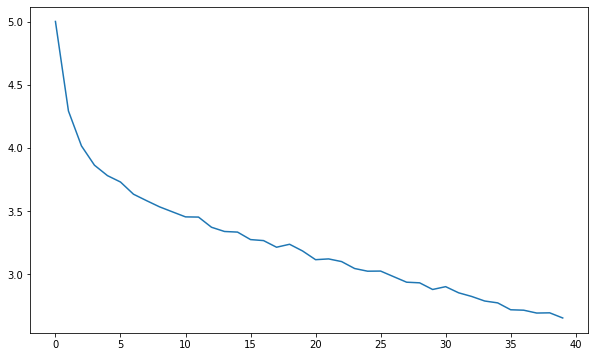

In [35]:
show_plot_evaluation(losses_history, 1)

## Evaluate The Network

Sequence of Operations:

1. Forward input through encoder model
2. Prepare encoder’s final hidden layer to be first hidden input to the decoder
3. Initialize decoder’s first input as SOS_token
4. Initialize tensors to append decoded words to
5. Iteratively decode one word token at a time: Forward pass through decoder, Obtain most likely word token and its softmax score, Record token and score, Prepare current token to be next decoder input
6. Return collections of word tokens and scores

In [36]:
class GreedySearchDecoder(nn.Module):
    
    def __init__(self, encoder, decoder):
        
        super(GreedySearchDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, input_seq, input_length, max_length):
        
        # forward input through encoder model
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length)
        
        # prepare encoder's final hidden layer to be first hidden input to the decoder
        decoder_hidden = encoder_hidden[:decoder.n_layers]
        
        # initialize decoder input with SOS_token
        decoder_input = torch.ones(1, 1, device=device, dtype=torch.long) * SOS_token
        
        # initialize tensors to append decoded words
        all_tokens = torch.zeros([0], device=device, dtype=torch.long)
        all_scores = torch.zeros([0], device=device)
        
        # iteratively decode one word token at a time
        for _ in range(MAX_LENGTH):
            
            # forward pass through decoder
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
            
            # obtain most likely word token and its softmax score
            decoder_scores, decoder_input = torch.max(decoder_output, dim=1)
            
            # record token and score
            all_tokens = torch.cat((all_tokens, decoder_input), dim=0)
            all_scores = torch.cat((all_scores, decoder_scores), dim=0)
            
            # prepare current token to be next decoder input (add a dimension)
            decoder_input = torch.unsqueeze(decoder_input, 0)
            
        # return collections of word tokens and scores
        return all_tokens, all_scores

#### Initialize Search Module

In [37]:
search_decoder = GreedySearchDecoder(encoder, decoder)
search_decoder.to(device)

GreedySearchDecoder(
  (encoder): Encoder(
    (embedding_layer): Embedding(7826, 500)
    (gru_layer): GRU(500, 500, num_layers=2, dropout=0.1, bidirectional=True)
  )
  (decoder): GlobalAttentionDecoder(
    (embedding_layer): Embedding(7826, 500)
    (embedding_dropout): Dropout(p=0.1, inplace=False)
    (gru_layer): GRU(500, 500, num_layers=2, dropout=0.1)
    (concat_layer): Linear(in_features=1000, out_features=500, bias=True)
    (fc_layer): Linear(in_features=500, out_features=7826, bias=True)
    (attention_layer): GlobalAttention()
  )
)

In [38]:
def evaluate_network(encoder, decoder, search_decoder, vocabulary, input_sequence, max_length=MAX_LENGTH):
    
    # format input sentence as a batch
    indexes_batch = [indexes_from_sentence(vocabulary, input_sequence, EOS_token)]
    
    # create lengths tensor
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    lengths = lengths.to(device)
    
    # transpose dimensions of batch to match models' expectations
    input_batch = torch.LongTensor(indexes_batch).transpose(0, 1)
    input_batch = input_batch.to(device)
    
    # decode sentence with search decoder
    tokens, scores = search_decoder(input_batch, lengths, max_length)
    decoded_words = [vocabulary.index2word[token.item()] for token in tokens]
    
    return decoded_words

In [39]:
def input_sentence(encoder, decoder, search_decoder, vocabulary):
    
    input_sequence = ''
    
    encoder.eval()
    decoder.eval()
    while(1):
        # get input sentence
        input_sentence = input('💻: ')

        # check if it is quit case
        if input_sentence == 'q' or input_sequence == 'quit': break

        # normalize sentence
        input_sentence = normalize_string(input_sentence)

        # evaluate sentence
        output_words = evaluate_network(encoder, decoder, search_decoder, vocabulary, input_sentence)

        # format and print response sentence
        output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
        print('🔥: ', ' '.join(output_words))

## Chat with Chatbot!

In [ ]:
input_sentence(encoder, decoder, search_decoder, vocabulary)

---